In [1]:
# Variabelen met meer correlatie verwijderd 

# ALLE HYPERPARAMETER DINGEN WEER TOEVOEGEN!!!

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, plot_confusion_matrix, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV,StratifiedShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint
from sklearn.linear_model import SGDClassifier


In [3]:
df_people_dataset = pd.read_csv('C:\\Users\\Mhell\\Downloads\\Thesis data\\people (1).csv.gz', encoding='ISO-8859-1')
df3_location_dataset = pd.read_csv('C:\\Users\\Mhell\\Downloads\\Thesis data\\locations.csv.gz', encoding='ISO-8859-1')
df4_connect_dataset = pd.read_csv('C:\\Users\\Mhell\\Downloads\\Thesis data\\connect.csv.gz', encoding='ISO-8859-1')

C:\Users\Mhell\AppData\Local\Temp\ipykernel_14420\1274915200.py:1: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_people_dataset = pd.read_csv('C:\\Users\\Mhell\\Downloads\\Thesis data\\people (1).csv.gz', encoding='ISO-8859-1')


In [4]:
# First we filter the instances who don't represent an collaboration and are an open end in the tree (pid2 is 0)
# we do this in df4: the 'connect' dataset containing collaborations between academici.
filtered_df = df4_connect_dataset[df4_connect_dataset['pid2'] != 0]

# Then we count the amount of chilren every PID1 has. We do this by counting how often they are in the PID1 column
# since every collaboartion represents a different instance.
frequentie = filtered_df['pid1'].value_counts()

# We counted the amount of children (fecundity) and safe it in a new variable: 'fecundity'
df4_connect_dataset['fecundity'] = df4_connect_dataset['pid1'].map(frequentie)

In [5]:
# In the 'people' dataset, containing all the individual researchers (represented by a personal indintificator (pid))
# we change pid to pid1 and connect the fecundity to this pid. After that, we add 'fecundity' to the connect dataset.
df_people_dataset = df_people_dataset.rename(columns={'pid': 'pid1'})
df_people_dataset = df_people_dataset.merge(df4_connect_dataset[['pid1', 'fecundity']], on='pid1', how='left')

# we change the name of the column back to the original (in the people dataset) and delete duplicates.
df_people_dataset = df_people_dataset.rename(columns={'pid1': 'pid'})
df_people_dataset = df_people_dataset.drop_duplicates(subset='pid', keep='first')

In [6]:
# we drop the unimportant columns in the connect dataset because we are using this dataset as the basis for the merged dataset
df4_connect_dataset.drop(['addedby', 'dateadded'], axis=1, inplace=True)
df_people_dataset.drop(['firstname', 'middlename', 'addedby','homepage', 'orcid_id', 's2id', 'dateadded','area','award','lastname'], axis=1, inplace=True)

In [7]:
# we create a subset with the relevant location feature from the location dataset
locations_subset = df3_location_dataset[['country', 'locid']]

# here we add the location subset (locid and country) to the people dataset. So we add an country to every location id.
df_people_dataset = pd.merge(df_people_dataset, locations_subset, on='locid', how='left')

In [8]:
# In this codeblock we link 'locid', 'country', 'majorarea', 'degrees', 'hindex' and 'fecundity' to both collaborators
# first we add this details to the first collaborator (PID1) and then to the seconf (PID2)
# we have to rename the column because we merge the dataset based on the pid from the people dataset.

df_people_dataset_subset = df_people_dataset[['pid','locid', 'country', 'majorarea', 'degrees', 'hindex', 'fecundity']]

df4_connect_dataset.rename(columns={'pid1': 'pid'}, inplace=True)

#merge
df4_connect_dataset_pid1 = pd.merge(df4_connect_dataset, df_people_dataset_subset, on='pid', how='left')

df4_connect_dataset_pid1.rename(columns={'pid': 'pid1'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'degrees': 'degrees1'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'locid_x': 'locid_cid'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'locid_y': 'locid1'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'majorarea': 'majorarea1'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'hindex': 'hindex1'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'country': 'country1'}, inplace=True)
df4_connect_dataset_pid1.rename(columns={'fecundity': 'fecundity1'}, inplace=True)

# and now for PID2
df4_connect_dataset_pid1.rename(columns={'pid2': 'pid'}, inplace=True)

df_people_dataset_subset2 = df_people_dataset[['pid','locid', 'country', 'majorarea', 'degrees', 'hindex', 'fecundity']]

merged_pid1_and_pid2 = pd.merge(df4_connect_dataset_pid1, df_people_dataset_subset2, on='pid', how='left')

merged_pid1_and_pid2.rename(columns={'pid': 'pid2'}, inplace=True)
merged_pid1_and_pid2.rename(columns={'degrees': 'degrees2'}, inplace=True)
merged_pid1_and_pid2.rename(columns={'locid': 'locid2'}, inplace=True)
merged_pid1_and_pid2.rename(columns={'majorarea': 'majorarea2'}, inplace=True)
merged_pid1_and_pid2.rename(columns={'hindex': 'hindex2'}, inplace=True)
merged_pid1_and_pid2.rename(columns={'country': 'country2'}, inplace=True)
merged_pid1_and_pid2.rename(columns={'fecundity': 'fecundity2'}, inplace=True)

thesis_dataset = merged_pid1_and_pid2

In [9]:
# rename fecundity
thesis_dataset.drop(columns=['fecundity_y'], inplace=True)
thesis_dataset.rename(columns={'fecundity_x': 'fecundity1'}, inplace=True)

In [10]:
# deleting the non-collaborations/open ends in the tree (PID2 is 0)
thesis_dataset = thesis_dataset[thesis_dataset['pid2'] != 0]

# deleting the collaborations who does not include two countries
thesis_dataset = thesis_dataset[thesis_dataset['country1'].notna() & thesis_dataset['country2'].notna()]

# fill up all the fecundity2 with NA, by 0 (because NA means they do not have children and their fecundity is 0)
thesis_dataset['fecundity2']=thesis_dataset['fecundity2'].fillna(0)

In [11]:
# clean the countries
%run cleaning.ipynb
thesis_dataset = clean_countries(thesis_dataset)

In [12]:
# Here we create a new variable: region. We map the countries into regions.

# 1 is North America
# 2 is Europe
# 3 is Asia
# 4 is Africa
# 5 is South America-Carribean-Central America
# 6 is Middle East and North Africa
# 7 is Oceania


region_mapping = {
    'United States': 1,
    'Canada': 1,
    'United Kingdom': 2,
    'Germany': 2,
    'Netherlands': 2,
    'France': 2,
    'Hong Kong': 3,
    'Australia': 7,
    'Switzerland': 2,
    'Israel': 6,
    'China': 3,
    'Japan': 3,
    'Sweden': 2,
    'Spain': 2,
    'Brazil': 5,
    'Italy': 2,
    'India': 3,
    'South Korea': 3,
    'Belgium': 2,
    'Austria': 2,
    'Hungary': 2,
    'Denmark': 2,
    'Singapore': 3,
    'New Zealand': 7,
    'Taiwan': 3,
    'Finland': 2,
    'Mexico': 5,
    'Greece': 2,
    'Ireland': 2,
    'Norway': 2,
    'Argentina': 5,
    'Russia': 3,
    'Chile': 5,
    'Turkey': 6,
    'Poland': 2,
    'Portugal': 2,
    'South Africa':4,
    'Czechia': 2,
    'Puerto Rico': 5,
    'Iran': 6,
    'Colombia': 5,
    'Thailand': 3,
    'Iceland': 2,
    'Cyprus': 2,
    'Slovakia': 2,
    'Cameroon': 4,
    'Venezuela': 5,
    'Philippines': 3,
    'Cuba': 5,
    'Korea': 3,
    'Ukraine': 2,
    'Estonia': 2,
    'Guam': 3,
    'Kuwait': 6,
    'Egypt': 6,
    'Uruguay': 5,
    'Bangladesh': 3,
    'Croatia': 2,
    'Indonesia': 3,
    'Romania': 2,
    'Malaysia': 3,
    'Slovenia': 2,
    'Lebanon': 6,
    'U.S. Virgin Islands': 5,
    'Panama': 5,
    'United Arab Emirates': 6,
    'Tunisia': 6,
    'Macedonia (FYROM)': 2,
    'Grenada': 5,
    'Vatican City': 2,
    'Georgia': 6,
    'Jordan': 6,
    'Nepal': 3,
    'Jamaica': 5,
    'Liberia': 4,
    'The Gambia': 4,
    'Armenia': 6,
    'Costa Rica': 5,
    'Uganda': 4,
    'Bulgaria': 2,
    'Kyrgyzstan': 3,
}

thesis_dataset['region1'] = thesis_dataset['country1'].map(region_mapping)
thesis_dataset['region2'] = thesis_dataset['country2'].map(region_mapping)

In [13]:
# Then we create another variable based on membership of the OECD

OECD_mapping = {
    'United States': 1,
    'Canada': 1,
    'United Kingdom': 1,
    'Germany': 1,
    'Netherlands': 1,
    'France': 1,
    'Hong Kong': 0,
    'Australia': 1,
    'Switzerland': 1,
    'Israel': 1,
    'China': 0,
    'Japan': 1,
    'Sweden': 1,
    'Spain': 1,
    'Brazil': 0,
    'Italy': 1,
    'India': 0,
    'South Korea': 0,
    'Belgium': 1,
    'Austria': 1,
    'Hungary': 1,
    'Denmark': 1,
    'Singapore': 0,
    'New Zealand': 1,
    'Taiwan': 0,
    'Finland': 1,
    'Mexico': 1,
    'Greece': 1,
    'Ireland': 1,
    'Norway': 1,
    'Argentina': 0,
    'Russia': 0,
    'Chile': 1,
    'Turkey': 1,
    'Poland': 1,
    'Portugal': 1,
    'South Africa':0,
    'Czechia': 1,
    'Puerto Rico': 0,
    'Iran': 0,
    'Colombia': 1,   
    'Thailand': 0,
    'Iceland': 1,
    'Cyprus': 0,
    'Slovakia': 1,
    'Cameroon': 0,
    'Venezuela': 0,
    'Philippines': 0,
    'Cuba': 0,
    'Korea': 0,
    'Ukraine': 0,
    'Estonia': 1,
    'Guam': 0,
    'Kuwait': 0,
    'Egypt': 0,
    'Uruguay': 0,
    'Bangladesh': 0,
    'Croatia': 0,
    'Indonesia': 0,
    'Romania': 0,
    'Malaysia': 0,
    'Slovenia': 1,
    'Lebanon': 0,
    'U.S. Virgin Islands': 0,
    'Panama': 0,    
    'United Arab Emirates': 0,
    'Tunisia': 0,
    'Macedonia (FYROM)': 0,
    'Grenada': 0,
    'Vatican City': 0,
    'Georgia': 0,
    'Jordan': 0,
    'Nepal': 0,
    'Jamaica': 0,
    'Liberia': 0,
    'The Gambia': 0,
    'Armenia': 0,
    'Costa Rica': 1,
    'Uganda': 0,
    'Bulgaria': 0,
    'Kyrgyzstan':0,
}

thesis_dataset['OECD1'] = thesis_dataset['country1'].map(OECD_mapping)
thesis_dataset['OECD2'] = thesis_dataset['country2'].map(OECD_mapping)

# Drop NAs
thesis_dataset = thesis_dataset.dropna(subset=['OECD1', 'OECD2'])

In [14]:
# Now we create the target variables based on the international and interregional collaboration
thesis_dataset['International collaboration'] = np.where(thesis_dataset['country1'] == thesis_dataset['country2'], 0, 1)
thesis_dataset['Interregional collaboration'] = np.where(thesis_dataset['region1'] == thesis_dataset['region2'], 0, 1)

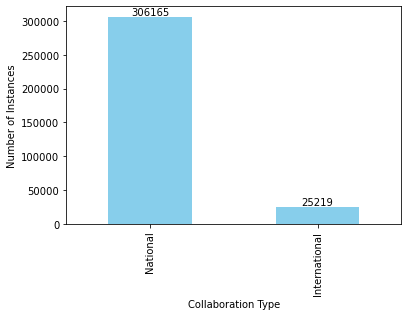

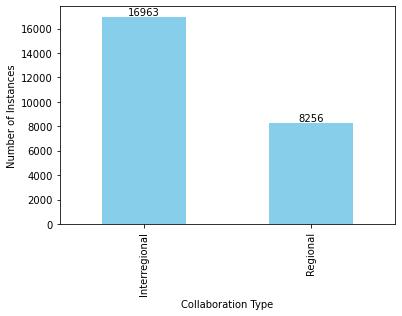

In [15]:
# We make graphics showing the amount of national, international, regional and interregional collaborations
# Creating a variable
thesis_dataset['collaboration_type'] = pd.NA
thesis_dataset.loc[(thesis_dataset['country1'] == thesis_dataset['country2']), 'collaboration_type'] = 'National'
thesis_dataset.loc[(thesis_dataset['country1'] != thesis_dataset['country2']), 'collaboration_type'] = 'International'

# Making a bar chart 
collaboration_counts = thesis_dataset['collaboration_type'].value_counts()
ax = collaboration_counts.plot(kind='bar', color='skyblue')

# Add labels
plt.title('')
plt.xlabel('Collaboration Type')
plt.ylabel('Number of Instances')

# Add the amount of instances in the bars
for i, v in enumerate(collaboration_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Print the plot
plt.show()

# The same steps for regional and interregional
thesis_dataset['collaboration_type'] = pd.NA
thesis_dataset.loc[(thesis_dataset['region1'] == thesis_dataset['region2']) & (thesis_dataset['country1'] != thesis_dataset['country2']), 'collaboration_type'] = 'Regional'
thesis_dataset.loc[(thesis_dataset['region1'] != thesis_dataset['region2']), 'collaboration_type'] = 'Interregional'

# Making a bar plot
collaboration_counts = thesis_dataset['collaboration_type'].value_counts()
ax = collaboration_counts.plot(kind='bar', color='skyblue')

# Titles and labels
plt.title('')
plt.xlabel('Collaboration Type')
plt.ylabel('Number of Instances')

# Amount of instances
for i, v in enumerate(collaboration_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Print the plot
plt.show()

# Delete the variable
thesis_dataset.drop(['collaboration_type'], axis=1, inplace=True)


In [16]:
# Clean the degrees
%run cleaning.ipynb
thesis_dataset = clean_degrees(thesis_dataset)

In [17]:
# Encoding 'degrees' into three categories 
categories_degrees = ['PhD', 'Ed.D.']

def encode_category(degree):
    if degree in categories_degrees:
        return degree  
    else:
        return 'Other'

thesis_dataset['degrees1'] = thesis_dataset['degrees1'].apply(encode_category)
thesis_dataset['degrees2'] = thesis_dataset['degrees2'].apply(encode_category)

In [18]:
# Encoding 'fecundity' into catagories to make it more likely there is overlap between both collaborators 
# 0:'0', 1:'1-5', 2:'6-10', 3:'11-15', 4:'16-20', 5:'21+'

category_edge = [(-1), 0, 5, 10, 15, 20, float ('inf')]
category_labels = [0, 1, 2, 3, 4, 5]

thesis_dataset['fecun_category1'] = pd.cut(thesis_dataset['fecundity1'], bins= category_edge, labels=category_labels).astype(int)
thesis_dataset['fecun_category2'] = pd.cut(thesis_dataset['fecundity2'], bins= category_edge, labels=category_labels).astype(int)


In [19]:
# For six elements a Jaccard similarity score is made to see how similar both collaborators are.

# Jaccard for the amounth of children the collaborators have (in categories)
thesis_dataset['jacc_fecun_cat'] = (thesis_dataset['fecun_category1'] == thesis_dataset['fecun_category2']).astype(int)

# Jaccard score for country
thesis_dataset['jacc_country'] = (thesis_dataset['country1'] == thesis_dataset['country2']).astype(int)

# Jaccard for degrees
thesis_dataset['jacc_degrees'] = (thesis_dataset['degrees1'] == thesis_dataset['degrees2']).astype(int)

# Jaccard score for region
thesis_dataset['jacc_region'] = (thesis_dataset['region1'] == thesis_dataset['region2']).astype(int)

# Jaccard score for OECD membership
thesis_dataset['jacc_OECD'] = (thesis_dataset['OECD1'] == thesis_dataset['OECD2']).astype(int)

# Jaccard: overlap for major area
def check_overlap(majorarea1, majorarea2):
    majorarea1_elements = majorarea1.split(',') 
    majorarea2_elements = majorarea2.split(',') 
    
    majorarea1_set = set(majorarea1_elements)
    majorarea2_set = set(majorarea2_elements)
    overlap_exists = len(majorarea1_set.intersection(majorarea2_set)) > 0
    
    jacc_majorarea = int(overlap_exists)
    
    return jacc_majorarea

# new column 'jacc_majorarea' 
thesis_dataset['jacc_majorarea'] = thesis_dataset.apply(lambda row: check_overlap(row['majorarea1'], row['majorarea2']), axis=1)

In [20]:
# Create the Jaccard Coefficient 
thesis_dataset['jaccard_coefficient'] = ( thesis_dataset['jacc_fecun_cat'] + thesis_dataset['jacc_country'] + thesis_dataset['jacc_degrees'] + thesis_dataset['jacc_region']+ thesis_dataset['jacc_OECD'] +thesis_dataset['jacc_majorarea']) / 6

In [21]:
# NANs per variable
nan_counts = thesis_dataset.isna().sum()
print(nan_counts)

cid                                 0
pid1                                0
pid2                                0
relation                            0
location                         7076
locid_cid                           0
startdate                           0
stopdate                            0
fecundity1                          0
locid1                              0
country1                            0
majorarea1                          0
degrees1                            0
hindex1                        289623
locid2                              0
country2                            0
majorarea2                          0
degrees2                            0
hindex2                        263833
fecundity2                          0
region1                             0
region2                             0
OECD1                               0
OECD2                               0
International collaboration         0
Interregional collaboration         0
fecun_catego

In [22]:
# Drop some useless variables for clarity, because of an high amounth of NANs or because the information in saved in other variables
thesis_dataset.drop(['pid1', 'pid2', 'cid','location', 'locid_cid', 'startdate','stopdate' ,'country1', 'country2', 'majorarea1', 
          'majorarea2', 'hindex1', 'hindex2', 'locid1', 'locid2',], axis=1, inplace=True)

In [23]:
# Encode categorical features
columns_to_encode = ['region1', 'region2','relation', 'fecun_category1', 'fecun_category2','degrees1', 'degrees2']
thesis_dataset = pd.get_dummies(thesis_dataset, columns=columns_to_encode, prefix=columns_to_encode, drop_first=True)

In [24]:
# Scale the continuous variables
features_to_scale = ['fecundity1', 'fecundity2']

# With standard scaler
scaler = StandardScaler()
thesis_dataset[features_to_scale] = scaler.fit_transform(thesis_dataset[features_to_scale])

In [25]:
from sklearn.model_selection import train_test_split

# Splits de data voor de eerste target variabele 'International collaboration'
y1 = thesis_dataset['International collaboration']

# Splits de data gestratificeerd (behoudt de originele verdeling van de target variabele)
train1, test1 = train_test_split(thesis_dataset, test_size=0.2, stratify=y1, random_state=101)

X_train1 = train1.drop('International collaboration', axis=1)
y_train1 = train1['International collaboration']

X_test1 = test1.drop('International collaboration', axis=1)
y_test1 = test1['International collaboration']

# Splits de data voor de tweede target variabele 'Interregional collaboration'
y2 = thesis_dataset['Interregional collaboration']

# Splits de data gestratificeerd (behoudt de originele verdeling van de target variabele)
train2, test2 = train_test_split(thesis_dataset, test_size=0.2, stratify=y2, random_state=101)

X_train2 = train2.drop('Interregional collaboration', axis=1)
y_train2 = train2['Interregional collaboration']

X_test2 = test2.drop('Interregional collaboration', axis=1)
y_test2 = test2['Interregional collaboration']


In [ ]:
# Hyperparameter tuning for the feature importance for 'international collaboration' with a Random Forest
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [int(x) for x in range(50, 251, 50)],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# RandomizedSearchCV on the training data
random_search.fit(X_train1, y_train1)

# Best parameters
best_params = random_search.best_params_
print('Best parameters for international collaboration', best_params)

# {'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 50}


All features and their importance for 'international collaboration':
jacc_country: 0.435995
jacc_region: 0.173646
Interregional collaboration: 0.171919
jaccard_coefficient: 0.104312
fecundity1: 0.022211
jacc_OECD: 0.017656
region2_2.0: 0.012483
region1_2.0: 0.012433
relation_1: 0.012038
jacc_majorarea: 0.007333
jacc_degrees: 0.006752
degrees1_Other: 0.006407
jacc_fecun_cat: 0.002585
fecun_category2_1: 0.002443
degrees2_Other: 0.002276
degrees1_PhD: 0.002172
fecundity2: 0.001365
relation_2: 0.001022
degrees2_PhD: 0.000788
OECD1: 0.000723
region1_3.0: 0.000501
region2_3.0: 0.000499
fecun_category1_2: 0.000449
region2_7.0: 0.000405
fecun_category2_2: 0.000374
relation_4: 0.000325
region1_7.0: 0.000226
OECD2: 0.000205
fecun_category1_3: 0.000104
fecun_category1_4: 7e-05
relation_3: 5.1e-05
region2_5.0: 4.1e-05
region2_4.0: 3.6e-05
fecun_category2_3: 3.1e-05
fecun_category1_5: 3e-05
region2_6.0: 2.8e-05
region1_6.0: 2.6e-05
fecun_category2_4: 2e-05
region1_5.0: 1.6e-05
region1_4.0: 1e-06
f

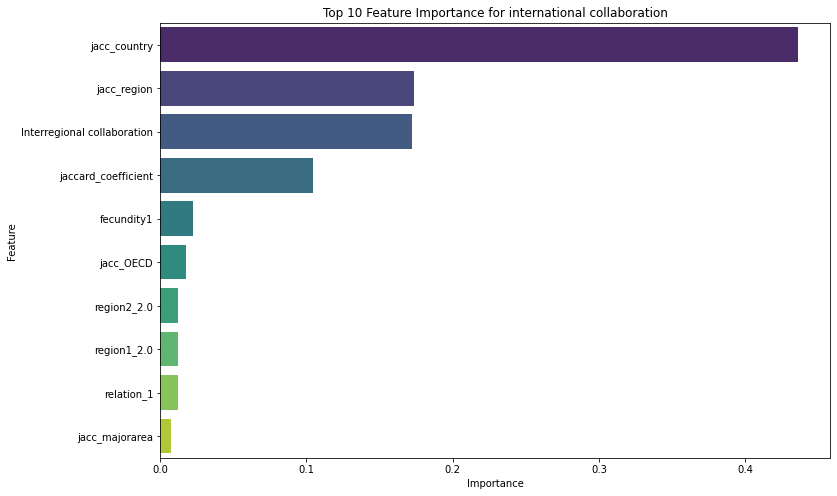

In [26]:
# Feature importance before feature selection by correlation
# RandomForestClassifier with the best hyperparameters for target variable 'international collaboration'
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=8,
    min_samples_leaf=1,
    max_depth=50,
    random_state=42)

# Fit the model
rf_classifier.fit(X_train1, y_train1)

# Feature importance without hyperparameter tuning
feature_importance1_rf = rf_classifier.feature_importances_

# Creating a DataFrame for the feature importance
feature_importance1 = pd.DataFrame({'Feature': X_train1.columns, 'Importance': feature_importance1_rf})
feature_importance1 = feature_importance1.sort_values(by='Importance', ascending=False)
feature_importance1['Importance'] = feature_importance1['Importance'].round(6)

# All features and their imporatnce
print("\nAll features and their importance for 'international collaboration':")
for feature, importance in zip(feature_importance1['Feature'], feature_importance1['Importance']):
    print(f"{feature}: {importance}")

# Then with a visualisation
top_features = feature_importance1.sort_values(by='Importance', ascending=False).head(10)

# With the top 10 
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importance for international collaboration')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Hyperparameter tuning for the feature importance for 'interregional collaboration' with a Random Forest
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [int(x) for x in range(50, 251, 50)],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

# Initialiseer de RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# RandomizedSearchCV on the training data
random_search.fit(X_train2, y_train2)

# Best parameters
best_params = random_search.best_params_
print('Best parameters for interregional collaboration', best_params)
# {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 50}


All features and their importance for 'interregional collaboration':
jacc_region: 0.406869
jaccard_coefficient: 0.177239
International collaboration: 0.146796
jacc_country: 0.143552
jacc_OECD: 0.026701
region2_2.0: 0.021065
region1_2.0: 0.01827
relation_1: 0.009178
fecundity1: 0.006994
jacc_degrees: 0.006476
jacc_fecun_cat: 0.005503
jacc_majorarea: 0.003515
region1_3.0: 0.003329
degrees1_Other: 0.002859
OECD2: 0.002838
fecundity2: 0.002575
OECD1: 0.002306
region2_3.0: 0.001904
relation_2: 0.001782
degrees1_PhD: 0.001611
region1_7.0: 0.001553
fecun_category2_1: 0.001415
region1_6.0: 0.000955
region2_7.0: 0.000884
region2_6.0: 0.00087
degrees2_Other: 0.000803
degrees2_PhD: 0.000693
region1_5.0: 0.000395
fecun_category1_2: 0.000342
relation_4: 0.000261
fecun_category2_2: 0.000149
region2_5.0: 0.00011
relation_3: 4.5e-05
fecun_category1_3: 4.3e-05
region1_4.0: 3.7e-05
region2_4.0: 2.7e-05
fecun_category1_4: 2.6e-05
fecun_category2_3: 2.2e-05
fecun_category2_4: 7e-06
fecun_category1_5: 2e-

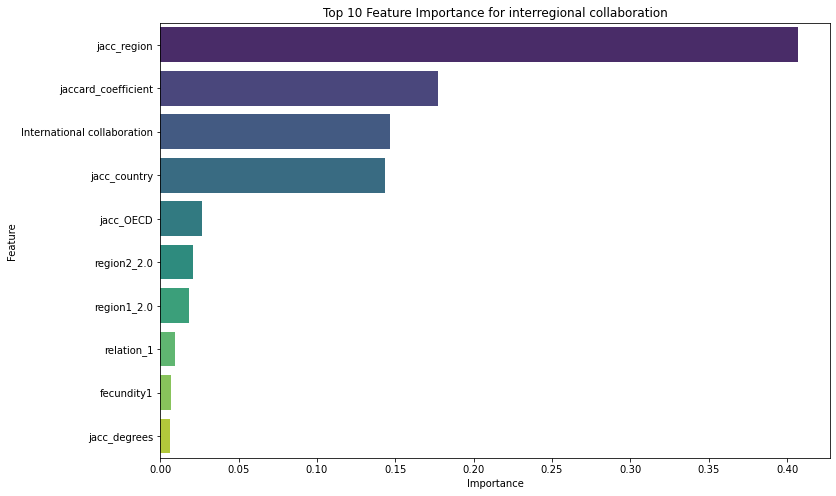

In [27]:
# Feature importance before feature selection by correlation
# RandomForestClassifier with the best hyperparameters for target variable 'interregional collaboration'
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=4,
    min_samples_leaf=1,
    max_depth=50,
    random_state=42)

# Fit the model
rf_classifier.fit(X_train2, y_train2)

# Feature importance without hyperparameter tuning
feature_importance2_rf = rf_classifier.feature_importances_

# Creating a DataFrame for the feature importance
feature_importance2 = pd.DataFrame({'Feature': X_train2.columns, 'Importance': feature_importance2_rf})
feature_importance2 = feature_importance2.sort_values(by='Importance', ascending=False)
feature_importance2['Importance'] = feature_importance2['Importance'].round(6)

# All features and their imporatnce
print("\nAll features and their importance for 'interregional collaboration':")
for feature, importance in zip(feature_importance2['Feature'], feature_importance2['Importance']):
    print(f"{feature}: {importance}")

# Then with a visualisation 
top_features = feature_importance2.sort_values(by='Importance', ascending=False).head(10)

# With the top 10
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importance for interregional collaboration')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

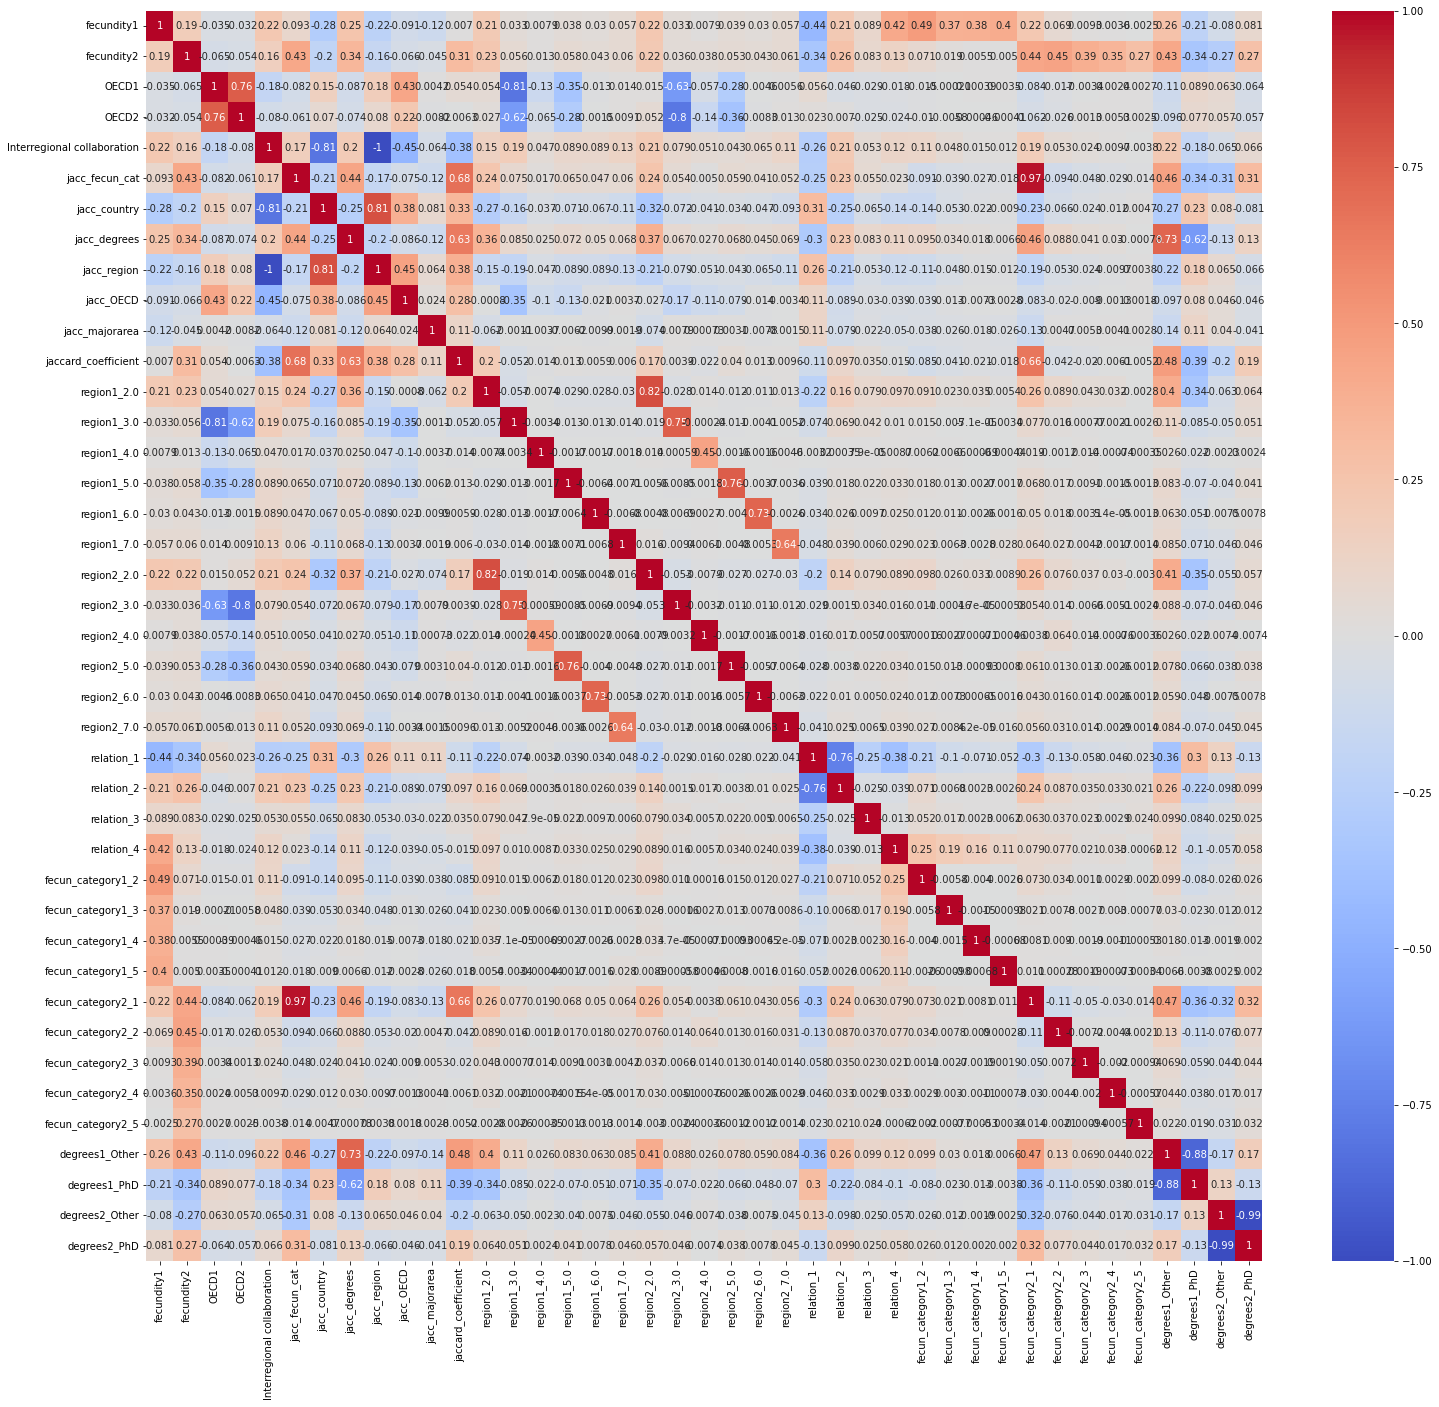

Top 20 highest correlaties for 'international collaboration':
                      Variable 1           Variable 2  Correlation
157  Interregional collaboration          jacc_region    -1.000000
819               degrees2_Other         degrees2_PhD    -0.994510
216               jacc_fecun_cat    fecun_category2_1     0.972023
814               degrees1_Other         degrees1_PhD    -0.877947
419                  region1_2.0          region2_2.0     0.818010
155  Interregional collaboration         jacc_country    -0.809480
226                 jacc_country          jacc_region     0.809480
89                         OECD1          region1_3.0    -0.805547
132                        OECD2          region2_3.0    -0.804113
500                  region1_5.0          region2_5.0     0.762534
79                         OECD1                OECD2     0.761474
684                   relation_1           relation_2    -0.755932
447                  region1_3.0          region2_3.0     0.753762


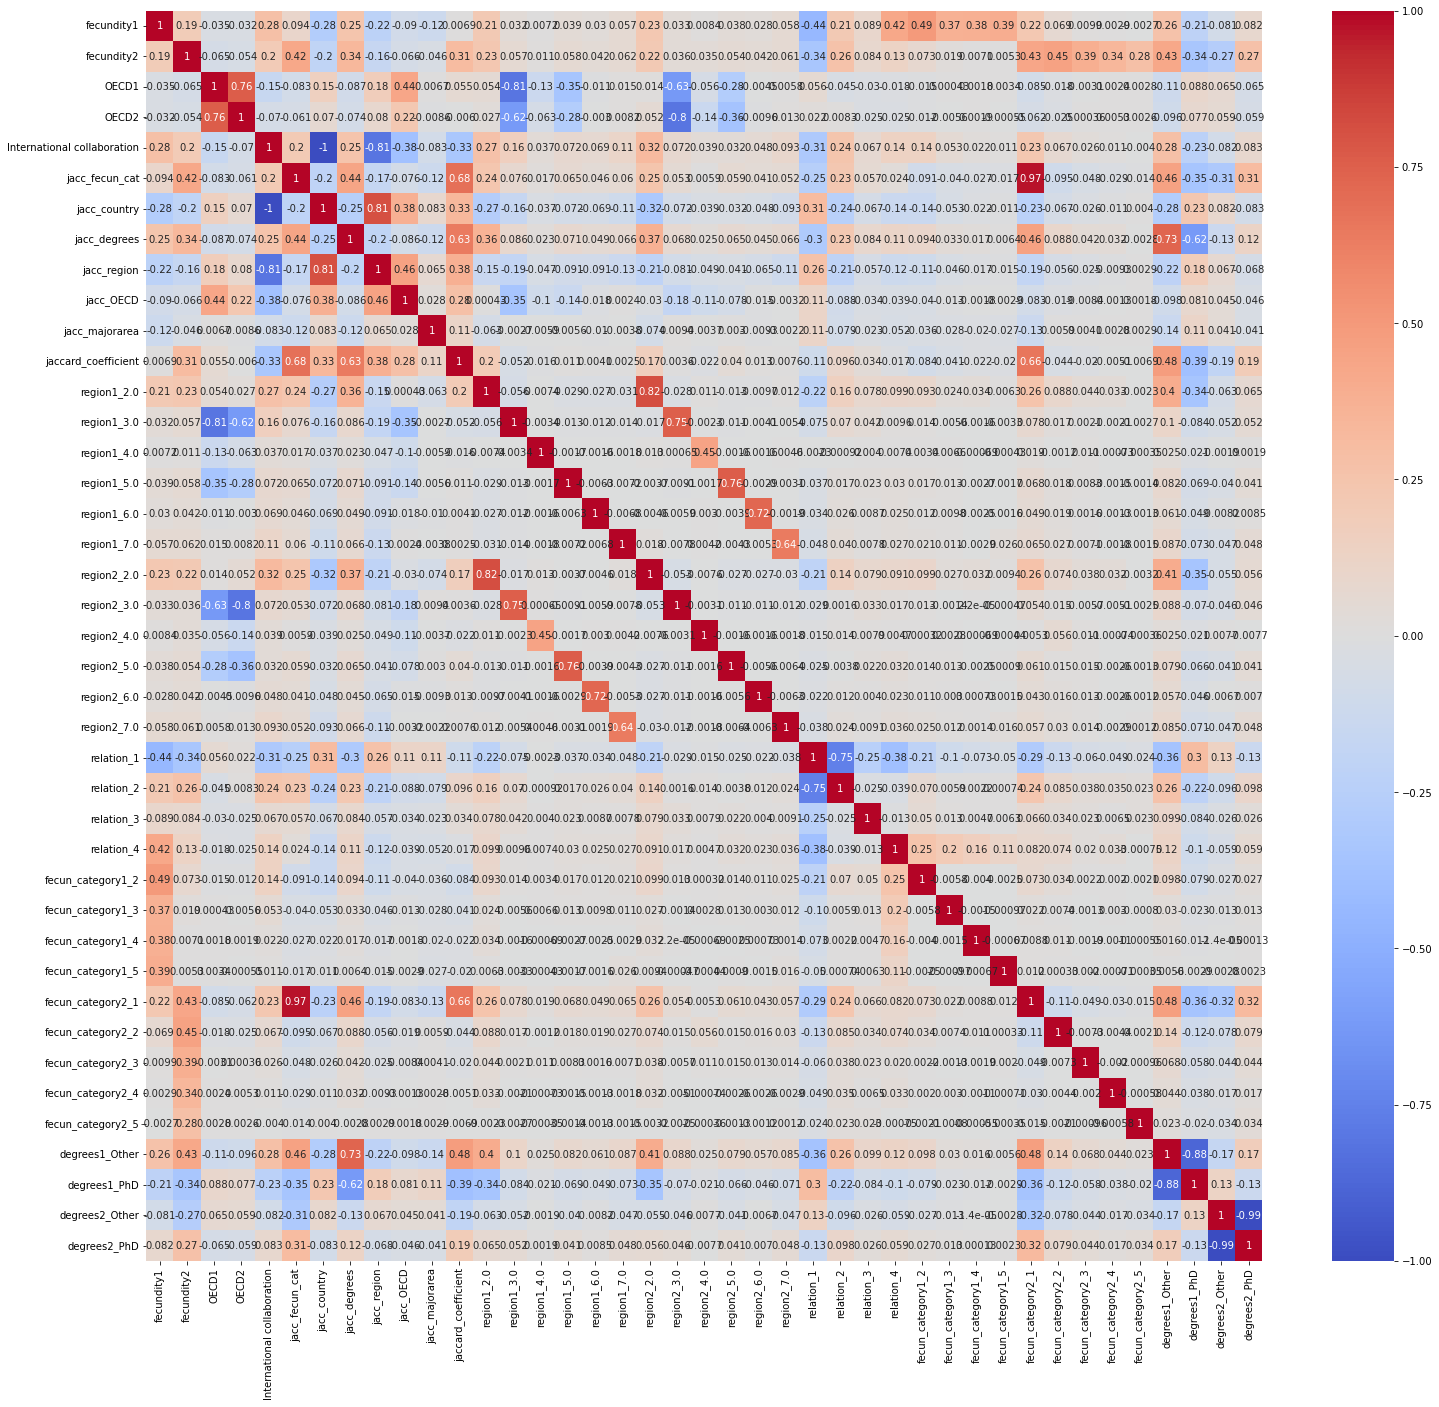

Top 20 highest correlaties for 'interregional collaboratoion':
                      Variable 1           Variable 2  Correlation
819               degrees2_Other         degrees2_PhD    -0.994511
216               jacc_fecun_cat    fecun_category2_1     0.971936
814               degrees1_Other         degrees1_PhD    -0.878616
419                  region1_2.0          region2_2.0     0.818514
226                 jacc_country          jacc_region     0.809270
157  International collaboration          jacc_region    -0.809270
89                         OECD1          region1_3.0    -0.805585
132                        OECD2          region2_3.0    -0.804988
500                  region1_5.0          region2_5.0     0.762305
79                         OECD1                OECD2     0.758827
684                   relation_1           relation_2    -0.754245
447                  region1_3.0          region2_3.0     0.751327
288                 jacc_degrees       degrees1_Other     0.727539

In [28]:
# Creating a correlation matrix for both target variables and the top 20 of correlations per target variable

# Correlation matrix for international collaboration 
cor_matrix1 = X_train1.corr()

plt.figure(figsize=(25,23))
sns.heatmap(cor_matrix1, annot=True, cmap='coolwarm')

plt.show()

# Rank the highest 20 correlations, not 1.
top_n = 20

highest_correlations_list = []

for i in range(len(cor_matrix1.columns)):
    for j in range(i+1, len(cor_matrix1.columns)):
        variable1 = cor_matrix1.columns[i]
        variable2 = cor_matrix1.columns[j]
        correlation = cor_matrix1.iloc[i, j]
        
        highest_correlations_list.append({'Variable 1': variable1,
                                          'Variable 2': variable2,
                                          'Correlation': correlation})

highest_correlations = pd.DataFrame(highest_correlations_list)

highest_correlations = highest_correlations.reindex(highest_correlations['Correlation'].abs().sort_values(ascending=False).index)

top_correlations = highest_correlations[highest_correlations['Correlation'].abs() < 1].head(top_n)

print("Top", top_n, "highest correlaties for 'international collaboration':")
print(top_correlations)

# Correlation matrix for interregional collaboration 
cor_matrix2 = X_train2.corr()

plt.figure(figsize=(25,23))
sns.heatmap(cor_matrix2, annot=True, cmap='coolwarm')

plt.show()

# The same top 20 ranking but then for 'interregional collaboration'
top_n = 20

highest_correlations_list = []

for i in range(len(cor_matrix2.columns)):
    for j in range(i+1, len(cor_matrix2.columns)):
        variable1 = cor_matrix2.columns[i]
        variable2 = cor_matrix2.columns[j]
        correlation = cor_matrix2.iloc[i, j]
        
        highest_correlations_list.append({'Variable 1': variable1,
                                          'Variable 2': variable2,
                                          'Correlation': correlation})

highest_correlations = pd.DataFrame(highest_correlations_list)

highest_correlations = highest_correlations.reindex(highest_correlations['Correlation'].abs().sort_values(ascending=False).index)

top_correlations = highest_correlations[highest_correlations['Correlation'].abs() < 1].head(top_n)

print("Top", top_n, "highest correlaties for 'interregional collaboratoion':")
print(top_correlations)


In [29]:
# Based on the highest correlation, five features per target variable are deleted
X_train1.drop(['region1_2.0', 'jacc_fecun_cat', 'jacc_degrees', 'jacc_OECD'], axis=1, inplace=True)
X_test1.drop(['region1_2.0', 'jacc_fecun_cat', 'jacc_degrees', 'jacc_OECD'], axis=1, inplace=True)
X_train2.drop(['region1_2.0', 'jacc_fecun_cat', 'jacc_degrees', 'jacc_OECD'], axis=1, inplace=True)
X_test2.drop(['region1_2.0', 'jacc_fecun_cat', 'jacc_degrees', 'jacc_OECD'], axis=1, inplace=True)

In [30]:
# Based on the highest correlation, five features per target variable are deleted
X_train1.drop([ 'Interregional collaboration','jacc_country','jacc_region','fecun_category2_1', 'degrees1_Other', 'degrees2_Other'], axis=1, inplace=True)
X_test1.drop(['Interregional collaboration','jacc_country','jacc_region','fecun_category2_1','degrees1_Other', 'degrees2_Other'], axis=1, inplace=True)
X_train2.drop([ 'International collaboration', 'jacc_country','jacc_region','fecun_category2_1', 'degrees1_Other', 'degrees2_Other'], axis=1, inplace=True)
X_test2.drop(['International collaboration','jacc_country', 'jacc_region', 'fecun_category2_1','degrees1_Other', 'degrees2_Other'], axis=1, inplace=True)

In [ ]:
# Hyperparameter tuning for the feature importance for 'international collaboration' with a Random Forest
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [int(x) for x in range(50, 251, 50)],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# RandomizedSearchCV on the training data
random_search.fit(X_train1, y_train1)

# Best parameters
best_params = random_search.best_params_
print('Best parameters for international collaboration', best_params)

# {'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 50}

In [ ]:
# Hyperparameter tuning for the feature importance for 'interregional collaboration' with a Random Forest
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [int(x) for x in range(50, 251, 50)],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

# Initialiseer de RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50, cv=5, random_state=42)

# RandomizedSearchCV on the training data
random_search.fit(X_train2, y_train2)

# Best parameters
best_params = random_search.best_params_
print('Best parameters for interregional collaboration', best_params)
# {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 50}


All features and their importance for 'international collaboration':
jaccard_coefficient: 0.531872
fecundity2: 0.077294
fecundity1: 0.063237
jacc_majorarea: 0.051563
region2_2.0: 0.04631
degrees2_PhD: 0.046304
degrees1_PhD: 0.045966
relation_1: 0.019994
relation_2: 0.017309
fecun_category2_2: 0.012583
region2_3.0: 0.011772
region1_3.0: 0.011497
OECD2: 0.011221
OECD1: 0.009777
region1_7.0: 0.009456
region2_7.0: 0.006702
fecun_category1_2: 0.006342
fecun_category2_3: 0.003423
region1_6.0: 0.003312
region2_6.0: 0.002521
region1_5.0: 0.002435
region2_5.0: 0.002067
relation_4: 0.002053
fecun_category2_4: 0.001265
fecun_category1_3: 0.001166
fecun_category1_4: 0.000638
relation_3: 0.000574
fecun_category2_5: 0.000426
fecun_category1_5: 0.000421
region2_4.0: 0.000293
region1_4.0: 0.000208


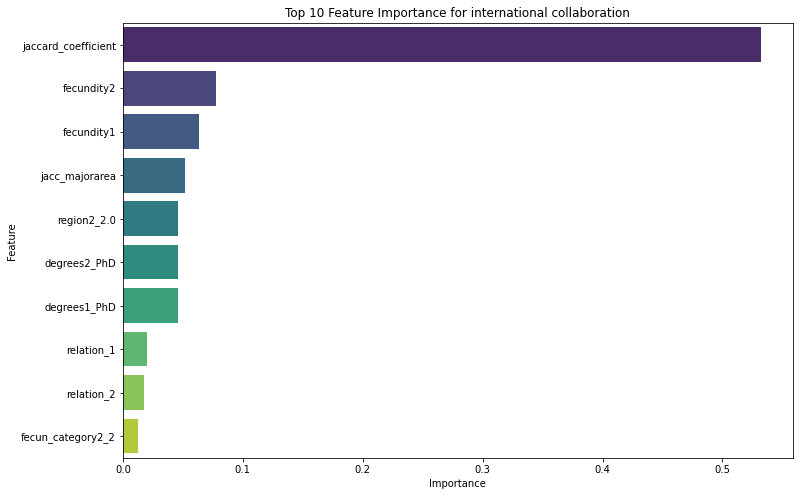

In [31]:
# RandomForestClassifier with the best hyperparameters for target variable 'international collaboration'
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    min_samples_split=8,
    min_samples_leaf=1,
    max_depth=50,
    random_state=42)

# Fit the model
rf_classifier.fit(X_train1, y_train1)

# Feature importance without hyperparameter tuning
feature_importance1_rf = rf_classifier.feature_importances_

# Creating a DataFrame for the feature importance
feature_importance1 = pd.DataFrame({'Feature': X_train1.columns, 'Importance': feature_importance1_rf})
feature_importance1 = feature_importance1.sort_values(by='Importance', ascending=False)
feature_importance1['Importance'] = feature_importance1['Importance'].round(6)

# All features and their imporatnce
print("\nAll features and their importance for 'international collaboration':")
for feature, importance in zip(feature_importance1['Feature'], feature_importance1['Importance']):
    print(f"{feature}: {importance}")

# Then with a visualisation
top_features = feature_importance1.sort_values(by='Importance', ascending=False).head(10)

# With the top 10 
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importance for international collaboration')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [32]:
# The variabeles to remove for target variable 'international collaboration'
# We keep the regions from PID1 for now
variables_to_remove = ['relation_1', 'degrees1_PhD', 'degrees2_PhD', 'relation_2', 'fecun_category2_2',
                        'OECD2', 'fecun_category1_2', 'region2_3.0', 'OECD1',
                        'region2_7.0', 'relation_4', 'fecun_category2_3',
                        'region2_6.0', 'fecun_category1_3', 'relation_3', 'fecun_category2_4',
                        'fecun_category1_4', 'region2_5.0', 'fecun_category1_5',
                        'fecun_category2_5', 'region2_4.0']

X_train1 = X_train1.drop(columns=variables_to_remove, errors='ignore')
X_test1 = X_test1.drop(columns=variables_to_remove, errors='ignore')


All features and their importance for 'interregional collaboration':
jaccard_coefficient: 0.550896
fecundity2: 0.06432
degrees2_PhD: 0.048236
fecundity1: 0.047693
jacc_majorarea: 0.042584
degrees1_PhD: 0.040314
region2_2.0: 0.022373
region2_3.0: 0.022274
region1_3.0: 0.02111
region1_7.0: 0.018143
OECD2: 0.017562
OECD1: 0.016683
region2_7.0: 0.014451
relation_1: 0.013762
relation_2: 0.012242
fecun_category2_2: 0.009939
region1_6.0: 0.008365
fecun_category1_2: 0.007191
region2_6.0: 0.006354
region1_5.0: 0.004456
region2_5.0: 0.003439
relation_4: 0.002345
fecun_category2_3: 0.001838
fecun_category1_3: 0.000876
fecun_category2_4: 0.000618
relation_3: 0.00051
fecun_category1_4: 0.00048
region1_4.0: 0.000336
region2_4.0: 0.000267
fecun_category1_5: 0.000182
fecun_category2_5: 0.00016


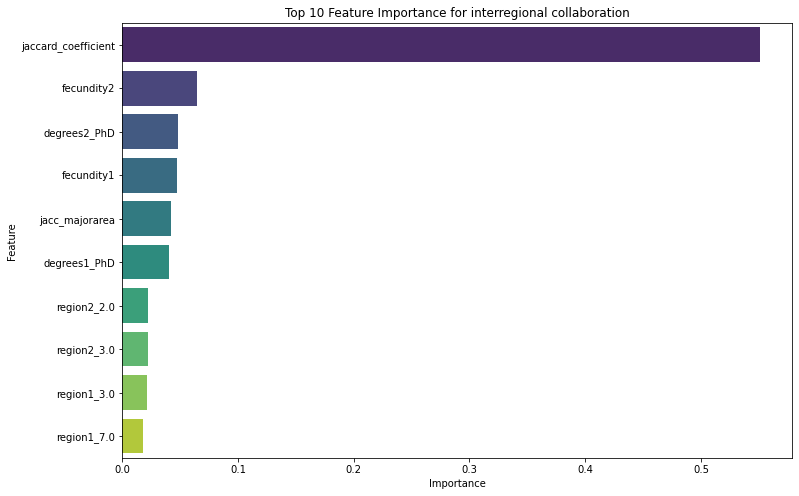

In [33]:
# RandomForestClassifier with the best hyperparameters for target variable 'interregional collaboration'
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=4,
    min_samples_leaf=1,
    max_depth=50,
    random_state=42)

# Fit the model
rf_classifier.fit(X_train2, y_train2)

# Feature importance without hyperparameter tuning
feature_importance2_rf = rf_classifier.feature_importances_

# Creating a DataFrame for the feature importance
feature_importance2 = pd.DataFrame({'Feature': X_train2.columns, 'Importance': feature_importance2_rf})
feature_importance2 = feature_importance2.sort_values(by='Importance', ascending=False)
feature_importance2['Importance'] = feature_importance2['Importance'].round(6)

# All features and their imporatnce
print("\nAll features and their importance for 'interregional collaboration':")
for feature, importance in zip(feature_importance2['Feature'], feature_importance2['Importance']):
    print(f"{feature}: {importance}")

# Then with a visualisation 
top_features = feature_importance2.sort_values(by='Importance', ascending=False).head(10)

# With the top 10
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Feature Importance for interregional collaboration')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [34]:
# Variables to be removed for target variable 'interregional collaboration'
# We keep the regions for now 
variables_to_remove = ['relation_1', 'region2_3.0', 'degrees1_PhD',
                        'region2_7.0', 'relation_2', 'degrees2_PhD', 'OECD1',
                        'OECD2', 'region2_6.0', 'fecun_category1_2', 'fecun_category2_2',
                        'region2_5.0', 'relation_4', 'fecun_category2_3', 'relation_3',
                        'fecun_category1_3', 'fecun_category1_4', 'region2_4.0', 'fecun_category2_4',
                        'fecun_category1_5', 'fecun_category2_5']

X_train2 = X_train2.drop(columns=variables_to_remove, errors='ignore')
X_test2 = X_test2.drop(columns=variables_to_remove, errors='ignore')

In [35]:
# Drop the regions who were not important enough
variables_to_drop = ['region1_3.0', 
                     'region1_7.0',  'region1_6.0',
                     'region1_5.0','region1_4.0' ]

X_train1 = X_train1.drop(columns=variables_to_drop, errors='ignore')
X_train2 = X_train2.drop(columns=variables_to_drop, errors='ignore')
X_test1 = X_test1.drop(columns=variables_to_drop, errors='ignore')
X_test2 = X_test2.drop(columns=variables_to_drop, errors='ignore')

In [36]:
# Baseline model for the full model on 'international collaboration'

# Baseline model training (Naive Bayes)
naive_bayes_model = BernoulliNB()
naive_bayes_model.fit(X_train1, y_train1)

# Predict on the test set
y_pred_test = naive_bayes_model.predict(X_test1)

# Predict on the training set
y_pred_train = naive_bayes_model.predict(X_train1)

# Classification report for the test set
print("Classification Report Naive Bayes for the Test Set (international collaboration):")
print(classification_report(y_test1, y_pred_test))

# AUC-ROC score for the test set
auc_roc_test = roc_auc_score(y_test1, y_pred_test)
print(f"AUC-ROC Score for the Test Set: {auc_roc_test}")

# Classification report for the training set
print("\nClassification Report Naive Bayes for the Training Set (international collaboration):")
print(classification_report(y_train1, y_pred_train))

# AUC-ROC score for the training set
auc_roc_train = roc_auc_score(y_train1, y_pred_train)
print(f"AUC-ROC Score for the Training Set: {auc_roc_train}")

Classification Report Naive Bayes for the Test Set (international collaboration):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     61233
           1       0.37      0.33      0.35      5044

    accuracy                           0.91     66277
   macro avg       0.66      0.64      0.65     66277
weighted avg       0.90      0.91      0.90     66277

AUC-ROC Score for the Test Set: 0.6412032640032425

Classification Report Naive Bayes for the Training Set (international collaboration):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    244932
           1       0.37      0.33      0.35     20175

    accuracy                           0.91    265107
   macro avg       0.66      0.64      0.65    265107
weighted avg       0.90      0.91      0.90    265107

AUC-ROC Score for the Training Set: 0.6410823318111447


In [37]:
# Baseline model for the full model on 'interregional collaboration'

naive_bayes_model = BernoulliNB()
naive_bayes_model.fit(X_train2, y_train2)

y_pred_test = naive_bayes_model.predict(X_test2)

# Predict on the training set
y_pred_train = naive_bayes_model.predict(X_train2)

# Classification report for the test set
print("Classification Report Naive Bayes for the Test Set (interregional collaboration):")
print(classification_report(y_test1, y_pred_test))

# Classification report for the training set
print("\nClassification Report Naive Bayes for the Training Set (interregional collaboration):")
print(classification_report(y_train1, y_pred_train))

# AUC-ROC score for the test set
auc_roc_test = roc_auc_score(y_test1, y_pred_test)
print(f"AUC-ROC Score for the Test Set: {auc_roc_test}")

auc_roc_test = roc_auc_score(y_train1, y_pred_train)
print(f"AUC-ROC Score for the Train Set: {auc_roc_test}")

y_pred_test_nb2 = naive_bayes_model.predict(X_test2)
y_pred_train_nb2 = naive_bayes_model.predict(X_train2)

Classification Report Naive Bayes for the Test Set (interregional collaboration):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     61233
           1       0.07      0.05      0.06      5044

    accuracy                           0.88     66277
   macro avg       0.50      0.50      0.50     66277
weighted avg       0.86      0.88      0.87     66277


Classification Report Naive Bayes for the Training Set (interregional collaboration):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93    244932
           1       0.08      0.05      0.06     20175

    accuracy                           0.88    265107
   macro avg       0.50      0.50      0.50    265107
weighted avg       0.86      0.88      0.87    265107

AUC-ROC Score for the Test Set: 0.49742396416863693
AUC-ROC Score for the Train Set: 0.5000332813714111


In [ ]:
# Hyperparameter tuning for Random Forest for 'international collaboration'
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)}

rf_classifier = RandomForestClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=10, cv=stratified_kfold, scoring='accuracy', random_state=42)
random_search.fit(X_train1, y_train1)

print(random_search.best_params_)
#{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 121}


Cross-Validation AUC-ROC Scores:
[0.99179015 0.9922895  0.99214156 0.99345094 0.99169101]
Mean AUC-ROC Score: 0.9922726304459285

Classification Report Random Forest for the Training Set (international collaboration):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    244932
           1       0.63      0.96      0.76     20175

    accuracy                           0.95    265107
   macro avg       0.81      0.96      0.87    265107
weighted avg       0.97      0.95      0.96    265107

AUC-ROC Score for the Training Set: 0.9588633816702451

Classification Report Random Forest for the Test Set (international collaboration):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     61233
           1       0.63      0.96      0.76      5044

    accuracy                           0.95     66277
   macro avg       0.81      0.96      0.87     66277
weighted avg       0.97      0.95      0.96

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


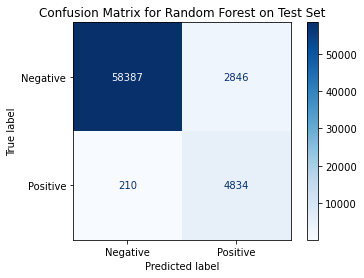

In [56]:
# Define the classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_hyperparameters, class_weight='balanced', random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(best_rf_classifier, X_train1, y_train1, cv=cv, scoring='roc_auc')

# Display cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores)}")

# Fit the model on the full training set
best_rf_classifier.fit(X_train1, y_train1)

# Predict on the training set
y_pred_train = best_rf_classifier.predict(X_train1)

# Classification report for the training set
print("\nClassification Report Random Forest for the Training Set (international collaboration):")
print(classification_report(y_train1, y_pred_train))

# AUC-ROC score for the training set
auc_roc_train = roc_auc_score(y_train1, y_pred_train)
print(f"AUC-ROC Score for the Training Set: {auc_roc_train}")

# Predict on the test set
y_pred_test = best_rf_classifier.predict(X_test1)

# Classification report for the test set
print("\nClassification Report Random Forest for the Test Set (international collaboration):")
print(classification_report(y_test1, y_pred_test))

# AUC-ROC score for the test set
auc_roc_test = roc_auc_score(y_test1, y_pred_test)
print(f"AUC-ROC Score for the Test Set: {auc_roc_test}")

# Plot confusion matrix for the test set
plot_confusion_matrix(best_rf_classifier, X_test1, y_test1, cmap=plt.cm.Blues, display_labels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Random Forest on Test Set")
plt.show()


In [ ]:
# Hyperparameter tuning for Random Forest for 'international collaboration'
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)}

rf_classifier = RandomForestClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=10, cv=stratified_kfold, scoring='accuracy', random_state=42)
random_search.fit(X_train2, y_train2)

print(random_search.best_params_)

#{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 121}

Cross-Validation AUC-ROC Scores:
[0.99789712 0.99815353 0.99803397 0.99828244 0.99790597]
Mean AUC-ROC Score: 0.9980546045930072

Classification Report Random Forest for the Training Set (interregional collaboration):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    251537
           1       0.88      1.00      0.94     13570

    accuracy                           0.99    265107
   macro avg       0.94      1.00      0.97    265107
weighted avg       0.99      0.99      0.99    265107

AUC-ROC Score for the Training Set: 0.9962649630074304

Classification Report Random Forest for the Test Set (interregional collaboration):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     62884
           1       0.88      1.00      0.94      3393

    accuracy                           0.99     66277
   macro avg       0.94      1.00      0.97     66277
weighted avg       0.99      0.99      0.99

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


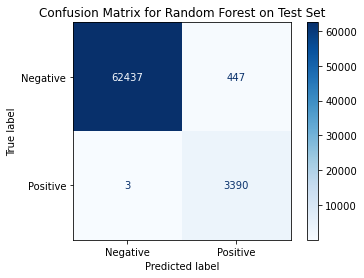

In [57]:
# Define the classifier with the best hyperparameters
best_rf_classifier = RandomForestClassifier(**best_hyperparameters, class_weight='balanced', random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(best_rf_classifier, X_train2, y_train2, cv=cv, scoring='roc_auc')

# Display cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores)}")

# Fit the model on the full training set
best_rf_classifier.fit(X_train2, y_train2)

# Predict on the training set
y_pred_train2 = best_rf_classifier.predict(X_train2)

# Classification report for the training set
print("\nClassification Report Random Forest for the Training Set (interregional collaboration):")
print(classification_report(y_train2, y_pred_train2))

# AUC-ROC score for the training set
auc_roc_train = roc_auc_score(y_train2, y_pred_train2)
print(f"AUC-ROC Score for the Training Set: {auc_roc_train}")

# Predict on the test set
y_pred_test2 = best_rf_classifier.predict(X_test2)

# Classification report for the test set
print("\nClassification Report Random Forest for the Test Set (interregional collaboration):")
print(classification_report(y_test2, y_pred_test2))

# AUC-ROC score for the test set
auc_roc_test = roc_auc_score(y_test2, y_pred_test2)
print(f"AUC-ROC Score for the Test Set: {auc_roc_test}")

# Plot confusion matrix for the test set
plot_confusion_matrix(best_rf_classifier, X_test2, y_test2, cmap=plt.cm.Blues, display_labels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Random Forest on Test Set")
plt.show()


In [ ]:
param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'subsample': [0.8, 0.9, 1.0],}

gb_classifier = GradientBoostingClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(gb_classifier, param_distributions=param_dist, n_iter=10, cv=stratified_kfold, scoring='accuracy', random_state=42)
random_search.fit(X_train1, y_train1)

print(random_search.best_params_)

#{'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 121, 'subsample': 0.8}


Cross-Validation AUC-ROC Scores:
[0.99302756 0.99316518 0.99344894 0.99336929 0.99282783]
Mean AUC-ROC Score: 0.993167762129018

Classificatierapport Gradient Boosting voor de trainingsset (internationale samenwerking):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    244932
           1       0.94      0.84      0.89     20175

    accuracy                           0.98    265107
   macro avg       0.96      0.92      0.94    265107
weighted avg       0.98      0.98      0.98    265107

AUC-ROC Score voor de trainingsset: 0.9169809722470881

Classificatierapport Gradient Boosting voor de testset (internationale samenwerking):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61233
           1       0.94      0.83      0.88      5044

    accuracy                           0.98     66277
   macro avg       0.96      0.91      0.94     66277
weighted avg       0.98      0.98      

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


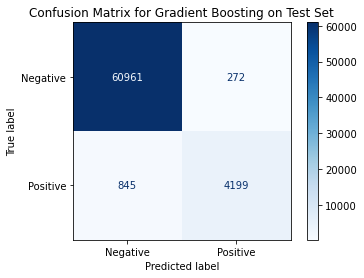

In [58]:
# Hyperparameters voor Gradient Boosting
hyperparameters = {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 121, 'subsample': 0.8}

# Initialiseer de GradientBoostingClassifier met de opgegeven hyperparameters
gb_classifier = GradientBoostingClassifier(**hyperparameters, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the training set
cv_scores = cross_val_score(gb_classifier, X_train1, y_train1, cv=cv, scoring='roc_auc')

# Display cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores)}")

# Fit het model op de trainingsdata
gb_classifier.fit(X_train1, y_train1)

# Voorspellingen op de trainingsset
y_pred_train1 = gb_classifier.predict(X_train1)

# Classificatierapport voor de trainingsset
print("\nClassificatierapport Gradient Boosting voor de trainingsset (internationale samenwerking):")
print(classification_report(y_train1, y_pred_train1))

# AUC-ROC score voor de trainingsset
auc_roc_train = roc_auc_score(y_train1, y_pred_train1)
print(f"AUC-ROC Score voor de trainingsset: {auc_roc_train}")

# Voorspellingen op de testset
y_pred_test1 = gb_classifier.predict(X_test1)

# Classificatierapport voor de testset
print("\nClassificatierapport Gradient Boosting voor de testset (internationale samenwerking):")
print(classification_report(y_test1, y_pred_test1))

# AUC-ROC score voor de testset
auc_roc_test = roc_auc_score(y_test1, y_pred_test1)
print(f"AUC-ROC Score voor de testset: {auc_roc_test}")

# Plot confusion matrix voor de testset
plot_confusion_matrix(gb_classifier, X_test1, y_test1, cmap=plt.cm.Blues, display_labels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Gradient Boosting on Test Set")
plt.show()


In [ ]:
param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'subsample': [0.8, 0.9, 1.0],}

gb_classifier = GradientBoostingClassifier(random_state=42)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(gb_classifier, param_distributions=param_dist, n_iter=10, cv=stratified_kfold, scoring='accuracy', random_state=42)
random_search.fit(X_train2, y_train2)

print(random_search.best_params_)

# {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 73, 'subsample': 1.0}


Cross-Validation AUC-ROC Scores:
[0.99800226 0.99815614 0.99814574 0.99826531 0.99796651]
Mean AUC-ROC Score: 0.9981071928397741

Classificatierapport Gradient Boosting voor de trainingsset (interregional samenwerking):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    251537
           1       0.88      1.00      0.93     13570

    accuracy                           0.99    265107
   macro avg       0.94      1.00      0.97    265107
weighted avg       0.99      0.99      0.99    265107

AUC-ROC Score voor de trainingsset: 0.9956465323995737

Classificatierapport Gradient Boosting voor de testset (interregional samenwerking):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     62884
           1       0.88      1.00      0.94      3393

    accuracy                           0.99     66277
   macro avg       0.94      1.00      0.97     66277
weighted avg       0.99      0.99      0

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


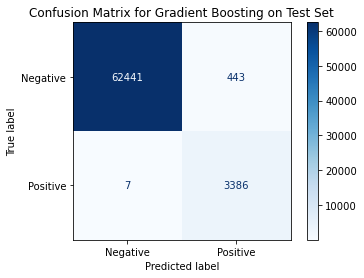

In [59]:
# Hyperparameters voor Gradient Boosting
hyperparameters = {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 121, 'subsample': 0.8}

# Initialiseer de GradientBoostingClassifier met de opgegeven hyperparameters
gb_classifier = GradientBoostingClassifier(**hyperparameters, random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on de trainingset
cv_scores = cross_val_score(gb_classifier, X_train2, y_train2, cv=cv, scoring='roc_auc')

# Display cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores)}")

# Fit het model op de trainingsdata
gb_classifier.fit(X_train2, y_train2)

# Voorspellingen op de trainingsset
y_pred_train2 = gb_classifier.predict(X_train2)

# Classificatierapport voor de trainingsset
print("\nClassificatierapport Gradient Boosting voor de trainingsset (interregional samenwerking):")
print(classification_report(y_train2, y_pred_train2))

# AUC-ROC score voor de trainingsset
auc_roc_train = roc_auc_score(y_train2, y_pred_train2)
print(f"AUC-ROC Score voor de trainingsset: {auc_roc_train}")

# Voorspellingen op de testset
y_pred_test2 = gb_classifier.predict(X_test2)

# Classificatierapport voor de testset
print("\nClassificatierapport Gradient Boosting voor de testset (interregional samenwerking):")
print(classification_report(y_test2, y_pred_test2))

# AUC-ROC score voor de testset
auc_roc_test = roc_auc_score(y_test2, y_pred_test2)
print(f"AUC-ROC Score voor de testset: {auc_roc_test}")

# Plot confusion matrix voor de testset
plot_confusion_matrix(gb_classifier, X_test2, y_test2, cmap=plt.cm.Blues, display_labels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Gradient Boosting on Test Set")
plt.show()


Classification Report Naive Bayes for the Test Set international (based on Jaccard Coefficient):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     61233
           1       1.00      0.00      0.00      5044

    accuracy                           0.92     66277
   macro avg       0.96      0.50      0.48     66277
weighted avg       0.93      0.92      0.89     66277


Classification Report Naive Bayes for the Training Set international (based on Jaccard Coefficient):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    244932
           1       1.00      0.00      0.00     20175

    accuracy                           0.92    265107
   macro avg       0.96      0.50      0.48    265107
weighted avg       0.93      0.92      0.89    265107

AUC-ROC Score for Naive Bayes test interregional: 0.5004
AUC-ROC Score for Naive Bayes train interregional: 0.5007


C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


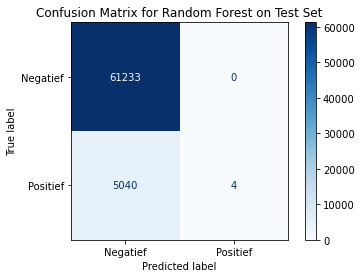

In [42]:
# Extract the 'jaccard_coefficient' feature
X_train_jaccard = X_train1[['jaccard_coefficient']]
X_test_jaccard = X_test1[['jaccard_coefficient']]

# Baseline model training (Naive Bayes) using only 'jaccard_coefficient'
naive_bayes_model = BernoulliNB()
naive_bayes_model.fit(X_train_jaccard, y_train1)

# Predict on the test set
y_pred_test = naive_bayes_model.predict(X_test_jaccard)

# Predict on the training set
y_pred_train = naive_bayes_model.predict(X_train_jaccard)

# Classification report for the test set
print("Classification Report Naive Bayes for the Test Set international (based on Jaccard Coefficient):")
print(classification_report(y_test1, y_pred_test))

# Classification report for the training set
print("\nClassification Report Naive Bayes for the Training Set international (based on Jaccard Coefficient):")
print(classification_report(y_train1, y_pred_train))

# Calculate AUC-ROC score for Naive Bayes
auc_roc_nb = roc_auc_score(y_test1, y_pred_test)
print(f"AUC-ROC Score for Naive Bayes test interregional: {auc_roc_nb:.4f}")

auc_roc_nb = roc_auc_score(y_train1, y_pred_train)
print(f"AUC-ROC Score for Naive Bayes train interregional: {auc_roc_nb:.4f}")

y_pred_test_nb = naive_bayes_model.predict(X_test_jaccard)

plot_confusion_matrix(naive_bayes_model, X_test_jaccard, y_test1, cmap=plt.cm.Blues, display_labels=['Negatief', 'Positief'])
plt.title("Confusion Matrix for Random Forest on Test Set")
plt.show()


Classification Report Naive Bayes for the Test Set interregional (based on Jaccard Coefficient):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     62884
           1       1.00      0.00      0.00      3393

    accuracy                           0.95     66277
   macro avg       0.97      0.50      0.49     66277
weighted avg       0.95      0.95      0.92     66277


Classification Report Naive Bayes for the Training Set interregional (based on Jaccard Coefficient):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    251537
           1       1.00      0.00      0.00     13570

    accuracy                           0.95    265107
   macro avg       0.97      0.50      0.49    265107
weighted avg       0.95      0.95      0.92    265107

AUC-ROC Score for Naive Bayes test interregional: 0.5012
AUC-ROC Score for Naive Bayes train interregional: 0.5009


C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


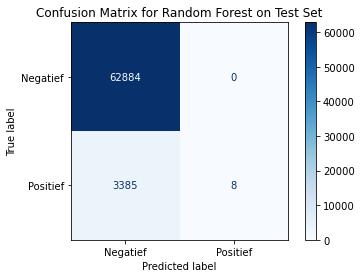

In [43]:
X_train_jaccard = X_train2[['jaccard_coefficient']]
X_test_jaccard = X_test2[['jaccard_coefficient']]

# Baseline model training (Naive Bayes) using only 'jaccard_coefficient'
naive_bayes_model = BernoulliNB()
naive_bayes_model.fit(X_train_jaccard, y_train2)

# Predict on the test set
y_pred_test = naive_bayes_model.predict(X_test_jaccard)

# Predict on the training set
y_pred_train = naive_bayes_model.predict(X_train_jaccard)

# Classification report for the test set
print("Classification Report Naive Bayes for the Test Set interregional (based on Jaccard Coefficient):")
print(classification_report(y_test2, y_pred_test))

# Classification report for the tin raining set
print("\nClassification Report Naive Bayes for the Training Set interregional (based on Jaccard Coefficient):")
print(classification_report(y_train2, y_pred_train))

# Predict on the test set
y_pred_test_nb = naive_bayes_model.predict(X_test_jaccard)

# Calculate AUC-ROC score for Naive Bayes
auc_roc_nb = roc_auc_score(y_test2, y_pred_test)
print(f"AUC-ROC Score for Naive Bayes test interregional: {auc_roc_nb:.4f}")

auc_roc_nb = roc_auc_score(y_train2, y_pred_train)
print(f"AUC-ROC Score for Naive Bayes train interregional: {auc_roc_nb:.4f}")

y_pred_test_nb = naive_bayes_model.predict(X_test_jaccard)

plot_confusion_matrix(naive_bayes_model, X_test_jaccard, y_test2, cmap=plt.cm.Blues, display_labels=['Negatief', 'Positief'])
plt.title("Confusion Matrix for Random Forest on Test Set")
plt.show()


In [60]:
# HYPER PARAMETER TUNING international collaboration with Jaccard Coefficient
X_train_jaccard = X_train1[['jaccard_coefficient']]
X_test_jaccard = X_test1[['jaccard_coefficient']]

# Model
rf_model = RandomForestClassifier(random_state=42)

# The hyperparameters with their options
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [50, 100, 150]
}

# StratifiedKFold for cross-validation, because of the inbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# using AUC-ROC as a scoring measure for optimization
als scoringsmaatstaf voor optimalisatie
scorer = make_scorer(roc_auc_score)

# Fit het randomized search model
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv=cv, scoring=scorer, random_state=42, n_iter=1000)
random_search.fit(X_train_jaccard, y_train1)

# Print the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Best hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

SyntaxError: invalid syntax (3361558661.py, line 20)

Cross-Validation AUC-ROC Scores:
[0.7742423  0.77904189 0.7790106  0.77493454 0.7781433 ]
Mean AUC-ROC Score: 0.77707452565368

Classificatierapport beste Random Forest (international) op de testset:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     61233
           1       0.91      0.45      0.60      5044

    accuracy                           0.95     66277
   macro avg       0.93      0.72      0.79     66277
weighted avg       0.95      0.95      0.95     66277


AUC-ROC Score beste Random Forest international op de testset:
0.7767

Classificatierapport beste Random Forest (international) op de trainingsset:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    244932
           1       0.91      0.44      0.60     20175

    accuracy                           0.95    265107
   macro avg       0.93      0.72      0.79    265107
weighted avg       0.95      0.95      0.95    26510

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


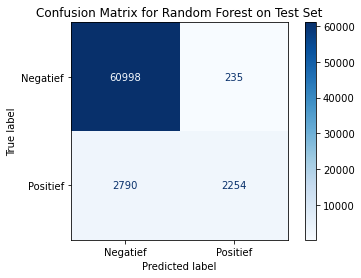

In [61]:
X_train_jaccard = X_train1[['jaccard_coefficient']]
X_test_jaccard = X_test1[['jaccard_coefficient']]

# Definieer het model
rf_model = RandomForestClassifier(random_state=42)

# Definieer de beste hyperparameters
best_params = {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

# Gebruik de beste gevonden hyperparameters voor je model
best_rf_model = RandomForestClassifier(random_state=42, **best_params)

# Perform cross-validation op de trainingset
cv_scores = cross_val_score(best_rf_model, X_train_jaccard, y_train1, cv=5, scoring='roc_auc')

# Toon de cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores)}")

# Fit het model op de trainingsdata
best_rf_model.fit(X_train_jaccard, y_train1)

# Voorspel de klassen op de testset
y_pred_best_rf = best_rf_model.predict(X_test_jaccard)

# Bereken de AUC-ROC score voor de testset
y_scores_best_rf = best_rf_model.predict_proba(X_test_jaccard)[:, 1]
auc_roc_best_rf = roc_auc_score(y_test1, y_scores_best_rf)

# Genereer de classificatiematrix en het classificatierapport voor de testset
conf_matrix_best_rf = confusion_matrix(y_test1, y_pred_best_rf)
class_report_best_rf = classification_report(y_test1, y_pred_best_rf)

# Toon het classificatierapport voor de testset
print("\nClassificatierapport beste Random Forest (international) op de testset:")
print(class_report_best_rf)

# Toon de AUC-ROC score voor de testset
print("\nAUC-ROC Score beste Random Forest international op de testset:")
print(f"{auc_roc_best_rf:.4f}")

# Bereken de AUC-ROC score voor de trainingsset
y_scores_train_rf = best_rf_model.predict_proba(X_train_jaccard)[:, 1]
auc_roc_train_rf = roc_auc_score(y_train1, y_scores_train_rf)

# Genereer het classificatierapport voor de trainingsset
class_report_train_rf = classification_report(y_train1, best_rf_model.predict(X_train_jaccard))

# Toon het classificatierapport voor de trainingsset
print("\nClassificatierapport beste Random Forest (international) op de trainingsset:")
print(class_report_train_rf)

# Toon de AUC-ROC score voor de trainingsset
print("\nAUC-ROC Score beste Random Forest international op de trainingsset:")
print(f"{auc_roc_train_rf:.4f}")

# Plot confusion matrix voor de testset
plot_confusion_matrix(best_rf_model, X_test_jaccard, y_test1, cmap=plt.cm.Blues, display_labels=['Negatief', 'Positief'])
plt.title("Confusion Matrix for Random Forest on Test Set")
plt.show()


In [ ]:
# HYPER PARAMETER TUNING interregional random forest with the Jaccard coefficient

X_train_jaccard = X_train2[['jaccard_coefficient']]
X_test_jaccard = X_test2[['jaccard_coefficient']]

# Definieer het model
rf_model = RandomForestClassifier(random_state=42)

# Definieer de hyperparameters en hun mogelijke waarden
param_dist = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [50, 100, 150]
}

# Gebruik StratifiedKFold voor cross-validation (rekening houdend met de onbalans in de klassen)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gebruik AUC-ROC als scoringsmaatstaf voor optimalisatie
scorer = make_scorer(roc_auc_score)

# Fit het randomized search model
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv=cv, scoring=scorer, random_state=42, n_iter=50)
random_search.fit(X_train_jaccard, y_train2)

# Toon de beste hyperparameters
best_params = random_search.best_params_
print("Beste hyperparameters:", best_params)

#Beste hyperparameters: {'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 20}

Cross-Validation AUC-ROC Scores:
[0.89015744 0.88792874 0.88975809 0.89032923 0.89107675]
Mean AUC-ROC Score: 0.8898500506435095

Classificatierapport beste Random Forest (interregional) op de testset:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     62884
           1       0.85      0.61      0.71      3393

    accuracy                           0.97     66277
   macro avg       0.91      0.80      0.85     66277
weighted avg       0.97      0.97      0.97     66277


AUC-ROC Score beste Random Forest interregional op de testset:
0.8897

Classificatierapport beste Random Forest (interregional) op de trainingsset:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    251537
           1       0.84      0.61      0.71     13570

    accuracy                           0.97    265107
   macro avg       0.91      0.80      0.85    265107
weighted avg       0.97      0.97      0.97    265

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


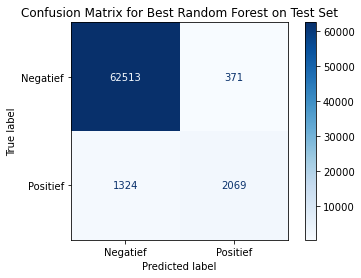

In [62]:
# Veronderstel dat X_train, y_train, X_test, y_test zijn gedefinieerd
X_train_jaccard = X_train2[['jaccard_coefficient']]
X_test_jaccard = X_test2[['jaccard_coefficient']]

# Definieer het model
rf_model = RandomForestClassifier(random_state=42)

# Definieer de beste hyperparameters
best_params = {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

# Gebruik de beste gevonden hyperparameters voor je model
best_rf_model = RandomForestClassifier(random_state=42, **best_params)

# Perform cross-validation op de trainingset
cv_scores = cross_val_score(best_rf_model, X_train_jaccard, y_train2, cv=5, scoring='roc_auc')

# Toon de cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores)}")

# Fit het model op de trainingsdata
best_rf_model.fit(X_train_jaccard, y_train2)

# Voorspel de klassen op de testset
y_pred_best_rf = best_rf_model.predict(X_test_jaccard)

# Bereken de AUC-ROC score voor de testset
y_scores_best_rf = best_rf_model.predict_proba(X_test_jaccard)[:, 1]
auc_roc_best_rf = roc_auc_score(y_test2, y_scores_best_rf)

# Genereer de classificatiematrix en het classificatierapport voor de testset
conf_matrix_best_rf = confusion_matrix(y_test2, y_pred_best_rf)
class_report_best_rf = classification_report(y_test2, y_pred_best_rf)

# Toon het classificatierapport voor de testset
print("\nClassificatierapport beste Random Forest (interregional) op de testset:")
print(class_report_best_rf)

# Toon de AUC-ROC score voor de testset
print("\nAUC-ROC Score beste Random Forest interregional op de testset:")
print(f"{auc_roc_best_rf:.4f}")

# Bereken de AUC-ROC score voor de trainingsset
y_scores_train_rf = best_rf_model.predict_proba(X_train_jaccard)[:, 1]
auc_roc_train_rf = roc_auc_score(y_train2, y_scores_train_rf)

# Genereer het classificatierapport voor de trainingsset
class_report_train_rf = classification_report(y_train2, best_rf_model.predict(X_train_jaccard))

# Toon het classificatierapport voor de trainingsset
print("\nClassificatierapport beste Random Forest (interregional) op de trainingsset:")
print(class_report_train_rf)

# Toon de AUC-ROC score voor de trainingsset
print("\nAUC-ROC Score beste Random Forest interregional op de trainingsset:")
print(f"{auc_roc_train_rf:.4f}")

# Plot confusion matrix voor de testset
plot_confusion_matrix(best_rf_model, X_test_jaccard, y_test2, cmap=plt.cm.Blues, display_labels=['Negatief', 'Positief'])
plt.title("Confusion Matrix for Best Random Forest on Test Set")
plt.show()


In [46]:
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 0.3}

# Data Voorbereiding
X_train_jaccard = X_train1[['jaccard_coefficient']]
X_test_jaccard = X_test1[['jaccard_coefficient']]

# Model Definitie
gb_model = GradientBoostingClassifier(random_state=42)

# Definiëren van Hyperparameter Ruimte
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1.0]
}

# Gebruik StratifiedKFold voor cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gebruik AUC-ROC als scoringsmaatstaf voor optimalisatie
scorer = make_scorer(roc_auc_score)

# Hyperparameter Tuning (Randomized Search)
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=50, cv=cv, scoring=scorer, random_state=42)
random_search_gb.fit(X_train_jaccard, y_train1)

# Toon de beste hyperparameters
best_params_gb = random_search_gb.best_params_
print("Beste hyperparameters voor Gradient Boosting international Jaccard coefficient:", best_params_gb)


Beste hyperparameters voor Gradient Boosting international Jaccard coefficient: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 0.3}


Cross-Validation AUC-ROC Scores:
[0.7742423  0.77904189 0.7790106  0.77493454 0.7781433 ]
Mean AUC-ROC Score: 0.77707452565368

Classificatierapport beste Gradient Boosting (test set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     61233
           1       0.91      0.45      0.60      5044

    accuracy                           0.95     66277
   macro avg       0.93      0.72      0.79     66277
weighted avg       0.95      0.95      0.95     66277


AUC-ROC Score beste Gradient Boosting (test set): 0.776664598669688

Classificatierapport beste Gradient Boosting (train set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    244932
           1       0.91      0.44      0.60     20175

    accuracy                           0.95    265107
   macro avg       0.93      0.72      0.79    265107
weighted avg       0.95      0.95      0.95    265107


AUC-ROC Score beste Gradient Boo

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


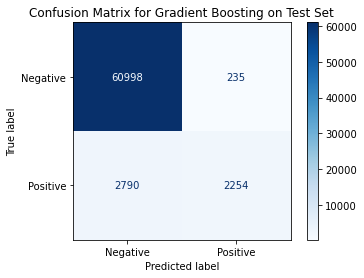

In [63]:
# Beste hyperparameters: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 0.3}
X_train_jaccard = X_train1[['jaccard_coefficient']]
X_test_jaccard = X_test1[['jaccard_coefficient']]

best_gb_model = GradientBoostingClassifier(random_state=42, **best_params_gb)

# Perform cross-validation op de trainingset
cv_scores_gb = cross_val_score(best_gb_model, X_train_jaccard, y_train1, cv=5, scoring='roc_auc')

# Toon de cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores_gb)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores_gb)}")

# Fit het model op de trainingsdata
best_gb_model.fit(X_train_jaccard, y_train1)

# Voorspel de klassen op de testset
y_pred_best_gb = best_gb_model.predict(X_test_jaccard)

# Bereken de AUC-ROC score voor de testset
y_scores_best_gb_test = best_gb_model.predict_proba(X_test_jaccard)[:, 1]
auc_roc_best_gb_test = roc_auc_score(y_test1, y_scores_best_gb_test)

# Genereer de classificatiematrix en het classificatierapport voor de testset
conf_matrix_best_gb_test = confusion_matrix(y_test1, y_pred_best_gb)
class_report_best_gb_test = classification_report(y_test1, y_pred_best_gb)

# Toon het classificatierapport en AUC-ROC score voor de testset
print("\nClassificatierapport beste Gradient Boosting (test set):")
print(class_report_best_gb_test)
print("\nAUC-ROC Score beste Gradient Boosting (test set):", auc_roc_best_gb_test)

# Voorspel de klassen op de trainingsset
y_pred_best_gb_train = best_gb_model.predict(X_train_jaccard)

# Bereken de AUC-ROC score voor de trainingsset
y_scores_best_gb_train = best_gb_model.predict_proba(X_train_jaccard)[:, 1]
auc_roc_best_gb_train = roc_auc_score(y_train1, y_scores_best_gb_train)

# Genereer de classificatiematrix en het classificatierapport voor de trainingsset
conf_matrix_best_gb_train = confusion_matrix(y_train1, y_pred_best_gb_train)
class_report_best_gb_train = classification_report(y_train1, y_pred_best_gb_train)

# Toon het classificatierapport en AUC-ROC score voor de trainingsset
print("\nClassificatierapport beste Gradient Boosting (train set):")
print(class_report_best_gb_train)
print("\nAUC-ROC Score beste Gradient Boosting (train set):", auc_roc_best_gb_train)

# Plot confusion matrix voor de testset
plot_confusion_matrix(best_gb_model, X_test_jaccard, y_test1, cmap=plt.cm.Blues, display_labels=['Negative', 'Positive'])
plt.title("Confusion Matrix for Gradient Boosting on Test Set")
plt.show()


In [48]:
# Hyperparameter tuning Interregional Gradient Boosting
# {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 0.3}

# Data Voorbereiding
X_train_jaccard = X_train2[['jaccard_coefficient']]
X_test_jaccard = X_test2[['jaccard_coefficient']]

# Model Definitie
gb_model = GradientBoostingClassifier(random_state=42)

# Definiëren van Hyperparameter Ruimte
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1.0]
}

# Gebruik StratifiedKFold voor cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gebruik AUC-ROC als scoringsmaatstaf voor optimalisatie
scorer = make_scorer(roc_auc_score)

# Hyperparameter Tuning (Randomized Search)
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist, n_iter=50, cv=cv, scoring=scorer, random_state=42)
random_search_gb.fit(X_train_jaccard, y_train2)

# Toon de beste hyperparameters
best_params_gb = random_search_gb.best_params_
print("Beste hyperparameters voor Gradient Boosting interregional:", best_params_gb)


Beste hyperparameters voor Gradient Boosting interregional: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 0.3}


Cross-Validation AUC-ROC Scores:
[0.89015744 0.88792874 0.88975809 0.89032923 0.89107675]
Mean AUC-ROC Score: 0.8898500506435095

Classificatierapport beste Gradient Boosting (test set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     62884
           1       0.85      0.61      0.71      3393

    accuracy                           0.97     66277
   macro avg       0.91      0.80      0.85     66277
weighted avg       0.97      0.97      0.97     66277


AUC-ROC Score beste Gradient Boosting (test set): 0.8897369223086636

Classificatierapport beste Gradient Boosting (train set):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    251537
           1       0.84      0.61      0.71     13570

    accuracy                           0.97    265107
   macro avg       0.91      0.80      0.85    265107
weighted avg       0.97      0.97      0.97    265107


AUC-ROC Score beste Gradient 

C:\Users\Mhell\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


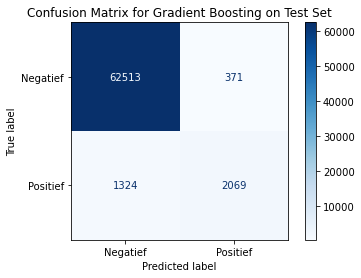

In [64]:
from sklearn.model_selection import cross_val_score

# Beste hyperparameters: {'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'learning_rate': 0.3}
X_train_jaccard = X_train2[['jaccard_coefficient']]
X_test_jaccard = X_test2[['jaccard_coefficient']]

best_gb_model = GradientBoostingClassifier(random_state=42, **best_params_gb)

# Perform cross-validation op de trainingset
cv_scores_gb = cross_val_score(best_gb_model, X_train_jaccard, y_train2, cv=5, scoring='roc_auc')

# Toon de cross-validation scores
print("Cross-Validation AUC-ROC Scores:")
print(cv_scores_gb)
print(f"Mean AUC-ROC Score: {np.mean(cv_scores_gb)}")

# Fit het model op de trainingsdata
best_gb_model.fit(X_train_jaccard, y_train2)

# Voorspel de klassen op de testset
y_pred_best_gb = best_gb_model.predict(X_test_jaccard)

# Bereken de AUC-ROC score voor de testset
y_scores_best_gb_test = best_gb_model.predict_proba(X_test_jaccard)[:, 1]
auc_roc_best_gb_test = roc_auc_score(y_test2, y_scores_best_gb_test)

# Genereer de classificatiematrix en het classificatierapport voor de testset
conf_matrix_best_gb_test = confusion_matrix(y_test2, y_pred_best_gb)
class_report_best_gb_test = classification_report(y_test2, y_pred_best_gb)

# Toon het classificatierapport en AUC-ROC score voor de testset
print("\nClassificatierapport beste Gradient Boosting (test set):")
print(class_report_best_gb_test)
print("\nAUC-ROC Score beste Gradient Boosting (test set):", auc_roc_best_gb_test)

# Voorspel de klassen op de trainingsset
y_pred_best_gb_train = best_gb_model.predict(X_train_jaccard)

# Bereken de AUC-ROC score voor de trainingsset
y_scores_best_gb_train = best_gb_model.predict_proba(X_train_jaccard)[:, 1]
auc_roc_best_gb_train = roc_auc_score(y_train2, y_scores_best_gb_train)

# Genereer de classificatiematrix en het classificatierapport voor de trainingsset
conf_matrix_best_gb_train = confusion_matrix(y_train2, y_pred_best_gb_train)
class_report_best_gb_train = classification_report(y_train2, y_pred_best_gb_train)

# Toon het classificatierapport en AUC-ROC score voor de trainingsset
print("\nClassificatierapport beste Gradient Boosting (train set):")
print(class_report_best_gb_train)
print("\nAUC-ROC Score beste Gradient Boosting (train set):", auc_roc_best_gb_train)

# Plot confusion matrix voor de testset
plot_confusion_matrix(best_gb_model, X_test_jaccard, y_test2, cmap=plt.cm.Blues, display_labels=['Negatief', 'Positief'])
plt.title("Confusion Matrix for Gradient Boosting on Test Set")
plt.show()
